In [9]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastbook import *

In [10]:
from fastai.vision.widgets import *
from fastai.vision.all import *

# Image classification

# Get the dataset:


In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Find our data and check its quality

In [12]:
# Search this folder to find where you copied the data on your drive:
%%bash
cd "/content/gdrive/"
ls

MyDrive
Shareddrives


In [15]:
%%bash
cd "../content/gdrive/My Drive/Colab Notebooks/datasets/"
cd "men-women-classification"
ls

men
women


In [16]:
# add the Path towards datasets/ to the "datasets" variable:
datasets = Path("../content/gdrive/My Drive/Colab Notebooks/datasets/")  # fill in the blank

# add 'men-women-classification' to the datasets Path object you just created
path = datasets.joinpath('men-women-classification')

assert path.ls()[0].name == 'men'

In [17]:
# use the get_image_files function to get the list of the filenames there are in
# the folder 'men-women-classification'

fns = get_image_files(path)

# You should have 3330 images
print(len(fns))
assert len(fns) == 3330

3330


In [ ]:

failed = verify_images(fns)
failed

## Create DataBlock, Dataloaders and use them to show some pictures

In [19]:
genders = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # tuple with ImageBlock and CategoryBlock
    get_items=get_image_files,  # use the get_image_files function
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # RandomSplitter
    get_y=parent_label,  # classes are separated into folders: use parent_label func
    item_tfms=Resize(128)  # for now, Resize the image in 128x128px
)

In [20]:
# Do it again, this time without hints:
genders = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [21]:

genders = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms=Resize(128)
)

assert type (genders) == DataBlock
assert genders.blocks[0] == TransformBlock
assert genders.get_items == get_image_files
assert genders.get_y == parent_label
assert type(genders.item_tfms[1]) == Resize

We have created a DataBlock, but we need to convert it to a dataloader before we can pass it to a learner.

In [23]:

dls = genders.dataloaders(path)
assert type(dls) == DataLoaders

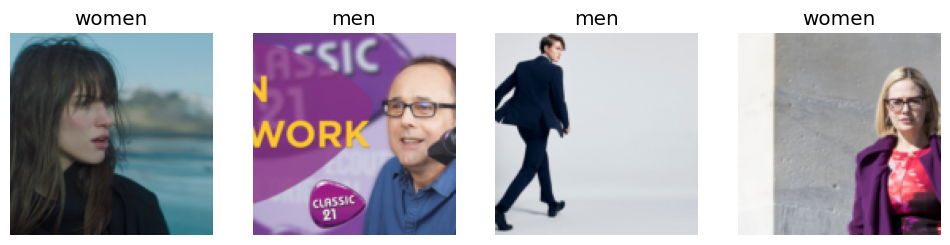

In [29]:
# Use the show_batch method to show 4 images of the train dataset
dls.train.show_batch(nrows=1,ncols=4)

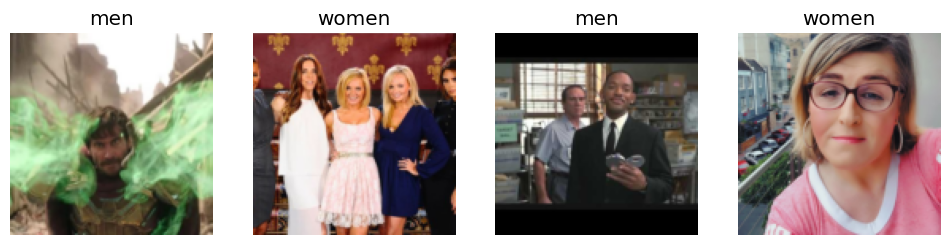

In [27]:
# Do the same thing to show some images of the validation dataset:
dls.valid.show_batch(nrows=1,ncols=4)

## Create the learner, and train it

Create your learner:
- call it learn
- pass it the resnet34 architecture
- pass error_rate as a metric

In [30]:

learn = vision_learner(dls, resnet34, metrics=error_rate)
assert type(learn) == Learner

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 166MB/s]


In [31]:
learn.fine_tune(4)

## Data augmentation
problems:
- few data = subpar results
- also, we passed 128px images to the model;

lets see if using a bigger image size and using data augmentation can help:

In [35]:

genders = genders.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())


# Once you have updated your DataBlock, you need to recreate your DataLoaders
# using it:
dls = genders.dataloaders(path)


Note: to be precise, we made a _copy_ of the genders DataBlock and assigned it to genders again. If we had assigned it to genders2, we'd have the old genders still alive, and genders2 which would be a copy + some modifications

In [36]:
# Re-create your learner, and fine-tune it again :
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)


# Interpretation !!

Interpretation is a very important part of machine learning. Thankfully the fastai provides an api that is way nicer than usual tools. We'll take a look at those:

In [37]:
# Create a ClassificationInterpretation object, and pass it your "l+earn" object
interp = ClassificationInterpretation.from_learner(learn)
assert type(interp) == ClassificationInterpretation

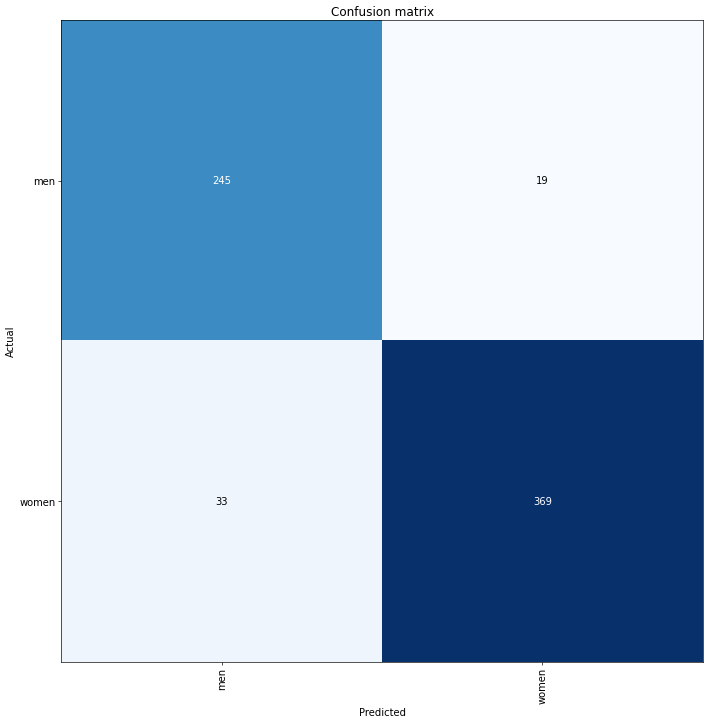

In [38]:
# this interp object has a method that plots a confusion matrix
# find it and use it:

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Note: take some time to consider how this confusion matrix is nicely printed. It makes it easy to understand and interpret. Kudos to the fastai team for putting so much attention into the details !

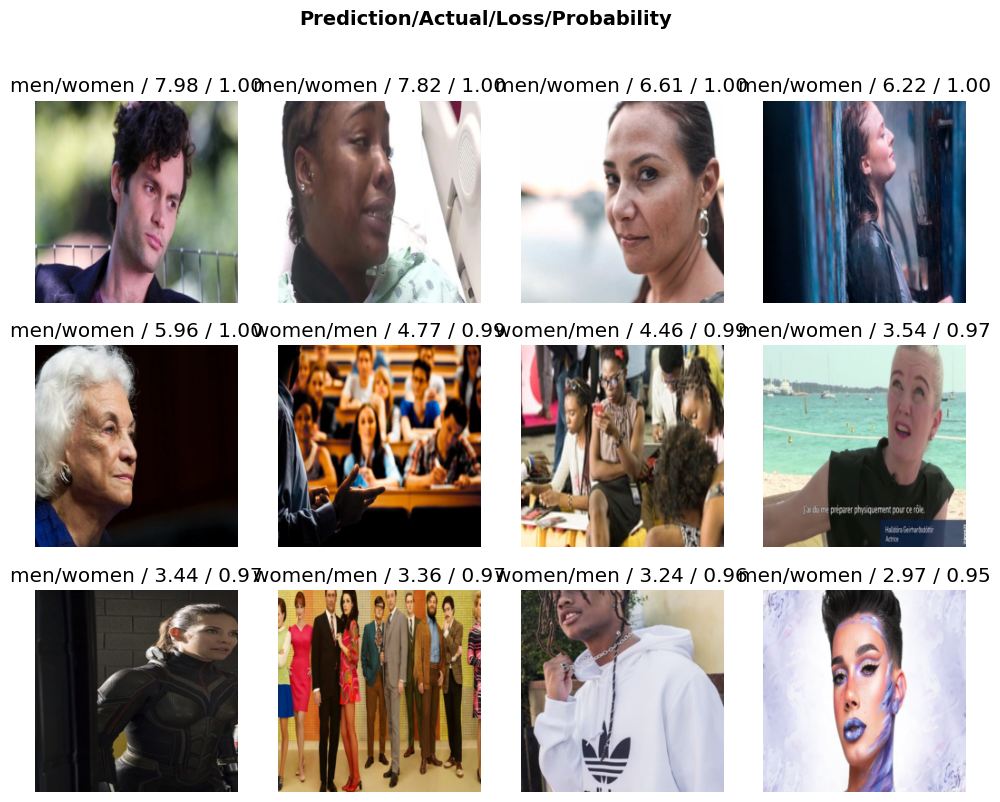

In [42]:

interp.plot_top_losses(12, nrows = 3)



## Inference time: export the model and make predictions

In [44]:
# Use the export method of your learner to, well, export it :-°
learn.export()

assert Path().ls(file_exts='.pkl')[0].name == 'export.pkl'
# Note: Path() just creates a Path object to the current directory

In [45]:
# Let's pretend you are now in the environnement of your web app.
# You uploaded the export.pkl file you created above.
# You know want to load it to use it and make prediction
# use the load_learner function to do that:

learn_inference = load_learner('export.pkl')
assert type(learn_inference) == Learner


We will now upload a picture a use our model to make the test. Use your pic or one of your friends. I used Jeremy's because that's an example everyone using this notebook should recognize.

In [50]:
# if not in Google Colab use :
# btn_upload = widgets.FileUpload()
# btn_upload

# in Google Colab, use:
from google.colab import files
myfile = files.upload()

Saving testimage.jpeg to testimage (1).jpeg


In [ ]:
img = PILImage.create('jeremy.jpg')

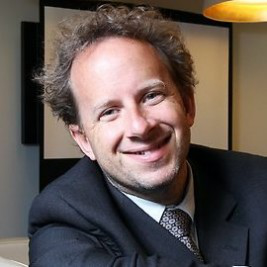

In [ ]:
img

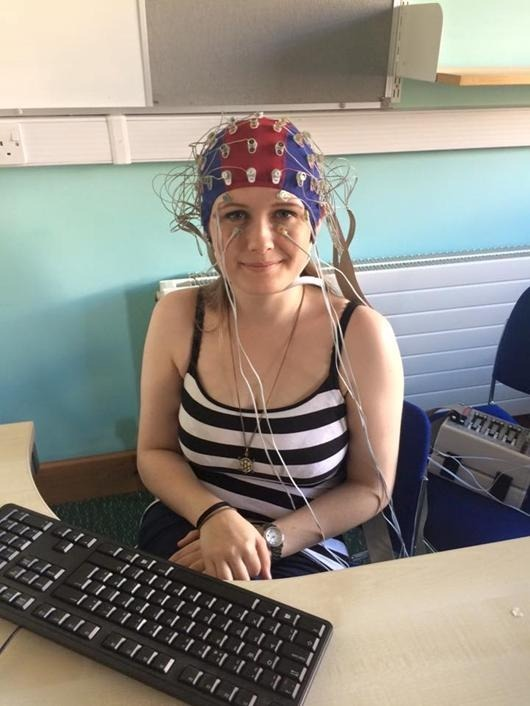

In [54]:
# Use the learn_inference model you created above to make a prediction on your picture:
img = PILImage.create('testimage.jpeg')
img


In [55]:
pred,pred_idx,probs = learn_inference.predict(img)
pred, pred_idx

('women', tensor(1))

In [ ]:
# probs contains the probabilities for each class.
# the sum of all probs elements should therefore be equal to one
# to print only the probability of the prediction, use probs[pred_idx]

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred